![](https://neurohive.io/wp-content/uploads/2019/01/resnet-e1548261477164.png)

![](https://miro.medium.com/max/704/1*WpX_8eCeTsEcCs8vdXtUCw.png)

![](https://d2l.ai/_images/resnet-block.svg)

![](https://neurohive.io/wp-content/uploads/2019/01/resnet-architectures-34-101.png)

In [1]:
import time
import copy

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from torch.utils.data.dataset import random_split
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler

import numpy as np

import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
num_epochs = 5
num_classes = 10
batch_size = 128
learning_rate = 0.001

In [4]:
torch.manual_seed(0)

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

train_dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('data', train=False, transform=transform)

# Before
print('Train data set:', len(train_dataset))
print('Test data set:', len(test_dataset))

# Random split
train_set_size = int(len(train_dataset) * 0.8)
indices = list(range(train_set_size))
split = int(np.floor(.2 * train_set_size))
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler =  SequentialSampler(val_indices)
   

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           sampler=train_sampler,
                                           batch_size=batch_size,
                                           )

valid_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           sampler=valid_sampler,
                                           batch_size=batch_size,
                                           )

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=False)

Train data set: 60000
Test data set: 10000


In [5]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, input_size, output_size, stride=1, down_sampling=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            input_size, output_size, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(output_size)
        self.conv2 = nn.Conv2d(output_size, output_size,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(output_size)
        self.relu = nn.ReLU(inplace=True)
        self.shortcut = nn.Sequential()
        if stride != 1 or input_size != output_size:
            self.shortcut = nn.Sequential(
                nn.Conv2d(input_size, self.expansion * output_size,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * output_size)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [6]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, input_size, output_size, stride=1, down_sampling=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(input_size, output_size,
                               kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(output_size)
        self.conv2 = nn.Conv2d(
            output_size, output_size, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(output_size)
        self.conv3 = nn.Conv2d(
            output_size, output_size * self.expansion, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(output_size * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.down_sampling = down_sampling
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.down_sampling is not None:
            identity = self.down_sampling(x)

        out += identity
        out = self.relu(out)

        return out

In [7]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.input_size = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, output_size, blocks, stride=1):
        down_sampling = None
        if stride != 1 or self.input_size != output_size * block.expansion:
            down_sampling = nn.Sequential(
                nn.Conv2d(self.input_size, output_size * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(output_size * block.expansion),
            )

        layers = []
        layers.append(
            block(self.input_size, output_size, stride, down_sampling))
        self.input_size = output_size * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.input_size, output_size))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [8]:
# ResNet18
# model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=number of classes you want to classify)

# ResNet34
# model = ResNet(BasicBlock, [3, 4, 6, 3], num_classes=number of classes you want to classify)

# ResNet50
# model = ResNet(Bottleneck, [3, 4, 6, 3], num_classes=number of classes you want to classify)

# ResNet101
# model = ResNet(Bottleneck, [3, 4, 23, 3], num_classes=number of classes you want to classify)

# ResNet150
# model = ResNet(Bottleneck, [3, 6, 36, 3], num_classes=number of classes you want to classify)

In [9]:
def train_val_model(model, criterion, optimizer, dataloaders, num_epochs=25,
        scheduler=None, log_interval=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Store losses and accuracies accross epochs
    losses, accuracies = dict(train=[], val=[]), dict(train=[], val=[])

    for epoch in range(num_epochs):
        if log_interval is not None and epoch % log_interval == 0:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            nsamples = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                nsamples += inputs.shape[0]

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if scheduler is not None and phase == 'train':
                scheduler.step()

            #nsamples = dataloaders[phase].dataset.data.shape[0]
            epoch_loss = running_loss / nsamples
            epoch_acc = running_corrects.double() / nsamples

            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            if log_interval is not None and epoch % log_interval == 0:
                print('{} Loss: {:.4f} Acc: {:.5f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        if log_interval is not None and epoch % log_interval == 0:
            print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.5f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, losses, accuracies

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

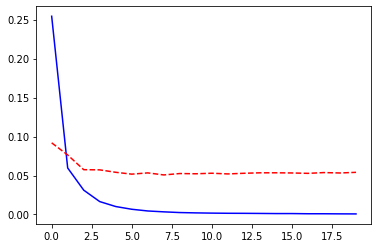

In [10]:
dataloaders = dict(train=train_loader, val=valid_loader)
criterion = torch.nn.CrossEntropyLoss()
model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
print(model)
print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))
model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders, num_epochs=20, log_interval=1)
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: {:.5f} '.format(correct / total))

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

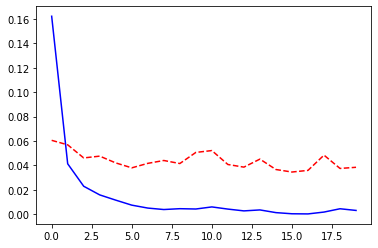

In [11]:
dataloaders = dict(train=train_loader, val=valid_loader)
criterion = torch.nn.CrossEntropyLoss()
model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=.9)
print(model)
print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))
model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders, num_epochs=20, log_interval=1)
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: {:.5f} '.format(correct / total))

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

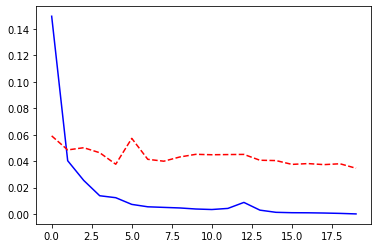

In [12]:
dataloaders = dict(train=train_loader, val=valid_loader)
criterion = torch.nn.CrossEntropyLoss()
model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=.9, nesterov=True)
print(model)
print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))
model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders, num_epochs=20, log_interval=1)
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: {:.5f} '.format(correct / total))

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

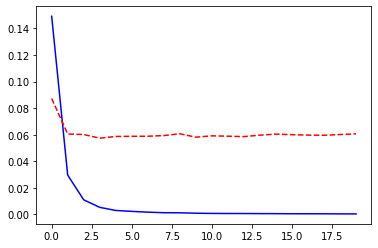

In [13]:
dataloaders = dict(train=train_loader, val=valid_loader)
criterion = torch.nn.CrossEntropyLoss()
model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes).to(device)
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
print(model)
print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))
model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders, num_epochs=20, log_interval=1)
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: {:.5f} '.format(correct / total))

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

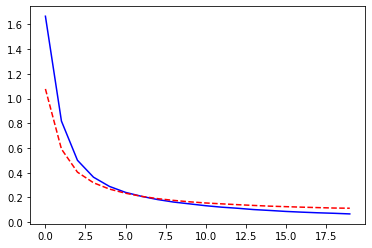

In [14]:
dataloaders = dict(train=train_loader, val=valid_loader)
criterion = torch.nn.CrossEntropyLoss()
model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes).to(device)
optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate)
print(model)
print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))
model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders, num_epochs=20, log_interval=1)
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: {:.5f} '.format(correct / total))

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

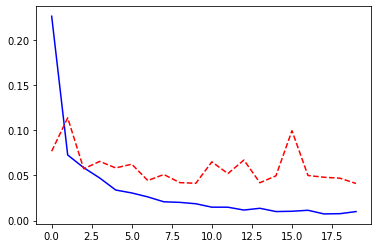

In [15]:
dataloaders = dict(train=train_loader, val=valid_loader)
criterion = torch.nn.CrossEntropyLoss()
model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes).to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
print(model)
print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))
model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders, num_epochs=20, log_interval=1)
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: {:.5f} '.format(correct / total))

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

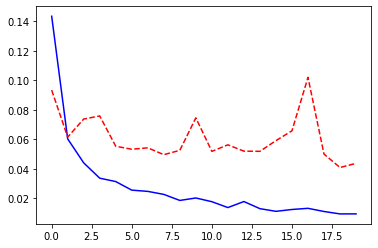

In [16]:
dataloaders = dict(train=train_loader, val=valid_loader)
criterion = torch.nn.CrossEntropyLoss()
model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)
print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))
model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders, num_epochs=20, log_interval=1)
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: {:.5f} '.format(correct / total))